In [ ]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap

In [5]:
# Load the wildfire HDF5 file for a specific day
file_path = "../../Calabria_dataset/InputReteGood/Target/2017/20170701.h5"

with h5py.File(file_path, "r") as h5_file:
    print("Top-level keys:", list(h5_file.keys()))
    for key in h5_file.keys():
        print(f"'{key}' contains:", list(h5_file[key].keys()))

Top-level keys: ['attributes', 'values']
'attributes' contains: ['_i_table', 'table']
'values' contains: ['_i_table', 'table']


In [6]:
# Extract attributes
with h5py.File(file_path, "r") as h5_file:
    attributes_table = h5_file["attributes/table"][:]

attribute_names = [attr[0].decode() for attr in attributes_table]
attribute_values = [attr[1][0] for attr in attributes_table]

attributes_dict = dict(zip(attribute_names, attribute_values))
attributes_dict

{'ncols': np.float32(1490.0),
 'nrows': np.float32(2592.0),
 'xllcorner': np.float32(549915.4),
 'yllcorner': np.float32(4189379.2),
 'cellsize': np.float32(100.0),
 'NODATA_value': np.float32(nan)}

In [7]:
# Extract ncols and nrows
ncols = int(attributes_dict["ncols"]) if "ncols" in attributes_dict else None
nrows = int(attributes_dict["nrows"]) if "nrows" in attributes_dict else None

print(f"Number of columns: {ncols}")
print(f"Number of rows: {nrows}")

Number of columns: 1490
Number of rows: 2592


In [8]:
# Load wildfire occurrence
with h5py.File(file_path, "r") as h5_file:
    values_table = h5_file["values/table"][:]

index_values = values_table["index"]
fire_results = values_table["values_block_0"].flatten()
fire_results


array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [9]:
# Index into row and column coordinates
row_coords = index_values // ncols 
col_coords = index_values % ncols 
row_coords, col_coords

(array([   0,    0,    0, ..., 2591, 2591, 2591]),
 array([   0,    1,    2, ..., 1487, 1488, 1489]))

In [10]:
# Create a DataFrame with spatial coordinates
df = pd.DataFrame({
    "Row": row_coords,
    "Column": col_coords,
    "Fire_Result": fire_results,
    "X_Coord": attributes_dict["xllcorner"] + (col_coords * attributes_dict["cellsize"]),
    "Y_Coord": attributes_dict["yllcorner"] + ((nrows - 1 - row_coords) * attributes_dict["cellsize"])
})

df

,Row,Column,Fire_Result,X_Coord,Y_Coord
0,0,0,NaN,549915.375,4448479.25
1,0,1,NaN,550015.375,4448479.25
2,0,2,NaN,550115.375,4448479.25
3,0,3,NaN,550215.375,4448479.25
4,0,4,NaN,550315.375,4448479.25
...,...,...,...,...,...
3862075,2591,1485,NaN,698415.375,4189379.25
3862076,2591,1486,NaN,698515.375,4189379.25
3862077,2591,1487,NaN,698615.375,4189379.25
3862078,2591,1488,NaN,698715.375,4189379.25


In [11]:
# Round Y coordinates
df["Y_Coord"] = df["Y_Coord"].round(-0).astype(float).round(1)
df

,Row,Column,Fire_Result,X_Coord,Y_Coord
0,0,0,NaN,549915.375,4448479.0
1,0,1,NaN,550015.375,4448479.0
2,0,2,NaN,550115.375,4448479.0
3,0,3,NaN,550215.375,4448479.0
4,0,4,NaN,550315.375,4448479.0
...,...,...,...,...,...
3862075,2591,1485,NaN,698415.375,4189379.0
3862076,2591,1486,NaN,698515.375,4189379.0
3862077,2591,1487,NaN,698615.375,4189379.0
3862078,2591,1488,NaN,698715.375,4189379.0


In [12]:
# Load precomputed cell-zone mapping
df_cell_zones = pd.read_parquet("cell_zones.parquet")
df_cell_zones

,Row,Column,X_Coord,Y_Coord,geometry,Zone_ID
0,74,179,567815.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\x0eT!A\...,8.0
1,74,180,567915.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xd6T!A\...,8.0
2,74,181,568015.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\x9eU!A\...,8.0
3,74,182,568115.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0fV!A\x00...,8.0
4,74,183,568215.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0.W!A\x00...,8.0
...,...,...,...,...,...,...
1507648,2550,712,621115.375,4444379.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0v\xf4""A\...",5.0
1507649,2550,713,621215.375,4444379.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0>\xf5""A\...",5.0
1507650,2551,711,621015.375,4444479.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xae\xf3...,5.0
1507651,2551,712,621115.375,4444479.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0v\xf4""A\...",5.0


In [14]:
# Load the zone shapefile
gdf_zones = gpd.read_file("1.2.Processed_Zones/cell_zones/cell_zones.shp")
gdf_zones

,Row,Column,X_Coord,Y_Coord,Zone_ID,geometry
0,74,179,567815.375,4196779.0,8.0,POINT (567815.375 4196779)
1,74,180,567915.375,4196779.0,8.0,POINT (567915.375 4196779)
2,74,181,568015.375,4196779.0,8.0,POINT (568015.375 4196779)
3,74,182,568115.375,4196779.0,8.0,POINT (568115.375 4196779)
4,74,183,568215.375,4196779.0,8.0,POINT (568215.375 4196779)
...,...,...,...,...,...,...
1507648,2550,712,621115.375,4444379.0,5.0,POINT (621115.375 4444379)
1507649,2550,713,621215.375,4444379.0,5.0,POINT (621215.375 4444379)
1507650,2551,711,621015.375,4444479.0,5.0,POINT (621015.375 4444479)
1507651,2551,712,621115.375,4444479.0,5.0,POINT (621115.375 4444479)


In [15]:
# Filter to only fire cells
df_fire_only = df[df["Fire_Result"] == 1].copy()
df_fire_only

,Row,Column,Fire_Result,X_Coord,Y_Coord
369719,248,199,1.0,569815.375,4423679.0
369720,248,200,1.0,569915.375,4423679.0
371204,249,194,1.0,569315.375,4423579.0
371205,249,195,1.0,569415.375,4423579.0
371206,249,196,1.0,569515.375,4423579.0
...,...,...,...,...,...
3281134,2202,154,1.0,565315.375,4228279.0
3282621,2203,151,1.0,565015.375,4228179.0
3282622,2203,152,1.0,565115.375,4228179.0
3282623,2203,153,1.0,565215.375,4228179.0


In [16]:
# Merge using aligned X/Y coordinates
df_fire_with_coords = df_cell_zones[["X_Coord", "Y_Coord", "Zone_ID"]].merge(
    df_fire_only,
    on=["X_Coord", "Y_Coord"],
    how="inner"
)

df_fire_with_coords

,X_Coord,Y_Coord,Zone_ID,Row,Column,Fire_Result
0,565115.375,4228079.0,4.0,2204,152,1.0
1,565015.375,4228179.0,4.0,2203,151,1.0
2,565115.375,4228179.0,4.0,2203,152,1.0
3,565215.375,4228179.0,4.0,2203,153,1.0
4,564915.375,4228279.0,4.0,2202,150,1.0
...,...,...,...,...,...,...
138,569815.375,4423579.0,1.0,249,199,1.0
139,569915.375,4423579.0,1.0,249,200,1.0
140,570015.375,4423579.0,1.0,249,201,1.0
141,569815.375,4423679.0,1.0,248,199,1.0


In [17]:
# Convert to GeoDataFrame
gdf_fire = gpd.GeoDataFrame(
    df_fire_with_coords,
    geometry=gpd.points_from_xy(df_fire_with_coords["X_Coord"], df_fire_with_coords["Y_Coord"]),
    crs="EPSG:32633"
)

gdf_fire

,X_Coord,Y_Coord,Zone_ID,Row,Column,Fire_Result,geometry
0,565115.375,4228079.0,4.0,2204,152,1.0,POINT (565115.375 4228079)
1,565015.375,4228179.0,4.0,2203,151,1.0,POINT (565015.375 4228179)
2,565115.375,4228179.0,4.0,2203,152,1.0,POINT (565115.375 4228179)
3,565215.375,4228179.0,4.0,2203,153,1.0,POINT (565215.375 4228179)
4,564915.375,4228279.0,4.0,2202,150,1.0,POINT (564915.375 4228279)
...,...,...,...,...,...,...,...
138,569815.375,4423579.0,1.0,249,199,1.0,POINT (569815.375 4423579)
139,569915.375,4423579.0,1.0,249,200,1.0,POINT (569915.375 4423579)
140,570015.375,4423579.0,1.0,249,201,1.0,POINT (570015.375 4423579)
141,569815.375,4423679.0,1.0,248,199,1.0,POINT (569815.375 4423679)


In [18]:
# Count the number of wildfire cells for the day
num_fires = gdf_fire.shape[0]
print("Total wildfire cells:", num_fires)

Total wildfire cells: 143


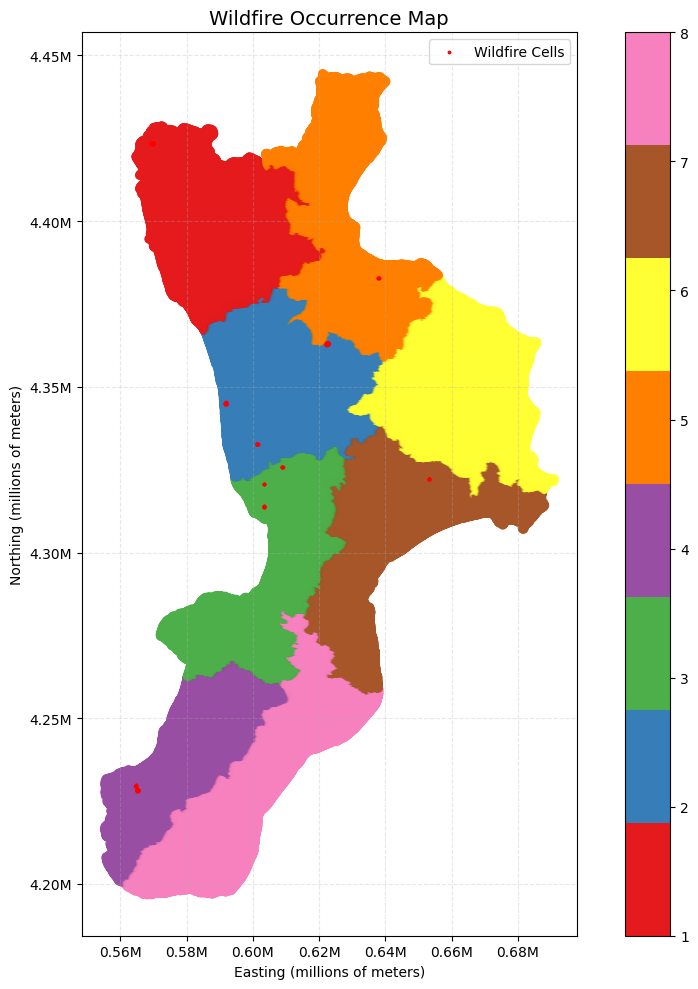

In [22]:
cmap = ListedColormap(plt.colormaps["Set1"].colors[:8])
gdf_zones = gpd.GeoDataFrame(df_cell_zones, 
                             geometry=gpd.points_from_xy(df_cell_zones.X_Coord, df_cell_zones.Y_Coord), 
                             crs="EPSG:32633")

fig, ax = plt.subplots(figsize=(10, 10))
gdf_zones.plot(column="Zone_ID", cmap=cmap, legend=True, ax=ax, markersize=30, alpha=0.5)
gdf_fire.plot(ax=ax, color="red", markersize=3, label="Wildfire Cells")
ax.set_title("Wildfire Occurrence Map", fontsize=14)
ax.set_xlabel("Easting (millions of meters)")
ax.set_ylabel("Northing (millions of meters)")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x * 1e-6:.2f}M"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y * 1e-6:.2f}M"))
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
